# Generative Adversarial Networks for Beginners
## Build a neural network that learns to generate handwritten digits.
### By [Jon Bruner](https://github.com/jonbruner) and [Adit Deshpande](https://github.com/adeshpande3)

This notebook accompanies [the O'Reilly interactive tutorial on generative adversarial networks](https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners). See the original tutorial to run this code in a pre-built environment on O'Reilly's servers with cell-by-cell guidance, or run this notebook on your own machine.

Also, see [gan-script.py](gan-script.py) in this repository for a straight Python implementation of this code.

### Prerequisites

You'll need [TensorFlow](https://www.tensorflow.org/install/), [NumPy](https://docs.scipy.org/doc/numpy/user/install.html), [matplotlib](https://matplotlib.org/) and [Jupyter](https://jupyter.readthedocs.io/en/latest/install.html) in order to run this notebook on your machine. See [the readme](https://github.com/jonbruner/generative-adversarial-networks) for advice on installing these packages.

## GAN architecture

Generative adversarial networks consist of two models: a generative model and a discriminative model.

![caption](notebook-images/GAN_Overall.png)

The discriminator model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).

The generator model takes random input values and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.

## Loading MNIST data

We need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images. We'll use [MNIST](http://yann.lecun.com/exdb/mnist/), a benchmark dataset in deep learning. It consists of 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students.

Let's start by importing TensorFlow along with a couple of other helpful libraries. We'll also import our MNIST images using a TensorFlow convenience function called `read_data_sets`.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

# Generator latent input size
z_dimensions = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def lrelu(x, leak=0.2, name="lrelu", do_summary=True):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        activation = f1 * x + f2 * abs(x)
        if do_summary:
            # Add summaries for helping debug
            tf.summary.histogram("activation", activation)
        return activation

(1, 784)


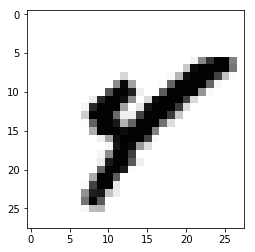

In [3]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

If you run the cell above again, you'll see a different image from the MNIST training set.

## Discriminator network

Our discriminator is a convolutional neural network that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake"—that is, whether it's drawn from the set of MNIST images or generated by the generator.

![caption](notebook-images/GAN_Discriminator.png)

The structure of our discriminator network is based closely on [TensorFlow's sample CNN classifier model](https://www.tensorflow.org/get_started/mnist/pros). It features two convolutional layers that find 5x5-pixel features, and two "fully connected" layers that multiply weights by every pixel in the image.

To set up each layer, we start by creating weight and bias variables through [`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable). Weights are initialized from a [truncated normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) distribution, and biases are initialized at zero.

[`tf.nn.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) is TensorFlow's standard convolution function. It takes 4 arguments. The first is the input volume (our `28 x 28 x 1` images in this case). The next argument is the filter/weight matrix. Finally, you can also change the stride and padding of the convolution. Those two values affect the dimensions of the output volume.

If you're already comfortable with CNNs, you'll recognize this as a simple binary classifier—nothing fancy. 

In [4]:
def discriminator(images):       
    # First convolutional and pool layers
    # This finds 32 different 5 x 5 pixel features
    d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
    d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
    d1 = d1 + d_b1
    d1 = lrelu(d1)
    d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Second convolutional and pool layers
    # This finds 64 different 5 x 5 pixel features
    d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
    d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
    d2 = d2 + d_b2
    d2 = lrelu(d2)
    d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # First fully connected layer
    d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
    d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
    d3 = tf.matmul(d3, d_w3)
    d3 = d3 + d_b3
    d3 = lrelu(d3)

    # Second fully connected layer
    d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
    d4 = tf.matmul(d3, d_w4) + d_b4

    # d4 contains unscaled values
    return d4

## Generator network

![caption](notebook-images/GAN_Generator.png)

Now that we have our discriminator defined, let’s take a look at the generator model. We'll base the overall structure of our model on a simple generator published by [Tim O'Shea](https://github.com/osh/KerasGAN).

You can think of the generator as a kind of reverse convolutional neural network. A typical CNN like our discriminator network transforms a 2- or 3-dimensional matrix of pixel values into a single probability. A generator, however, takes a `d`-dimensional vector of noise and upsamples it to become a 28 x 28 image. ReLU and batch normalization are used to stabilize the outputs of each layer.

In our generator network, we use three convolutional layers along with interpolation until a `28 x 28` pixel image is formed. (Actually, as you'll see below, we've taken care to form `28 x 28 x 1` images; many TensorFlow tools for dealing with images anticipate that the images will have some number of _channels_—usually 1 for greyscale images or 3 for RGB color images.)

At the output layer we add a [`tf.sigmoid()`](https://www.tensorflow.org/api_docs/python/tf/sigmoid) activation function; this squeezes pixels that would appear grey toward either black or white, resulting in a crisper image.

In [5]:
def generator(z, batch_size, z_dim):   
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

## Training a GAN

One of the trickiest parts about building and tuning GANs is that they have two loss functions: one that encourages the generator to create better images, and the other that encourages the discriminator to distinguish generated images from real images.

We train both the generator and the discriminator simultaneously. As the discriminator gets better at distinguishing real images from generated images, the generator is able to better tune its weights and biases to generate convincing images.

Here are the inputs and outputs for our networks.

In [6]:
tf.reset_default_graph()
batch_size = 50

# z_placeholder is for feeding input noise to the generator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 

# x_placeholder is for feeding input images to the discriminator
x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 

# Create the GAN model
with tf.variable_scope('GAN'):
    with tf.variable_scope("G") as scope:
        # Gz holds the generated images
        Gz = generator(z_placeholder, batch_size, z_dimensions)         

    # Discriminator
    with tf.variable_scope("D") as scope:
        # Dx will hold discriminator prediction probabilities for the real MNIST images
        Dx = discriminator(x_placeholder)         

        # Mark to reuse variables 
        # https://www.tensorflow.org/programmers_guide/variable_scope
        # https://stackoverflow.com/questions/37098546/difference-between-variable-and-get-variable-in-tensorflow
        scope.reuse_variables()
        # Dg will hold discriminator prediction probabilities for generated images
        Dg = discriminator(Gz)
        

So, let’s first think about what we want out of our networks. The discriminator's goal is to correctly label real MNIST images as real (return a higher output) and generated images as fake (return a lower output). We'll calculate two losses for the discriminator: one loss that compares `Dx` and 1 for real images from the MNIST set, as well as a loss that compares `Dg` and 0 for images from the generator. We'll do this with TensorFlow's [`tf.nn.sigmoid_cross_entropy_with_logits()`](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) function, which calculates the cross-entropy losses between `Dx` and 1 and between `Dg` and 0.

`sigmoid_cross_entropy_with_logits` operates on unscaled values rather than probability values from 0 to 1. Take a look at the last line of our discriminator: there's no softmax or sigmoid layer at the end. GANs can fail if their discriminators "saturate," or become confident enough to return exactly 0 when they're given a generated image; that leaves the discriminator without a useful gradient to descend.

The [`tf.reduce_mean()`](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) function takes the mean value of all of the components in the matrix returned by the cross entropy function. This is a way of reducing the loss to a single scalar value, instead of a vector or matrix.

In [7]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

Now let's set up the generator's loss function. We want the generator network to create images that will fool the discriminator: the generator wants the discriminator to output a value close to 1 when it's given an image from the generator. Therefore, we want to compute the loss between `Dg` and 1.

In [8]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))  

Now that we have our loss functions, we need to define our optimizers. The optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. Likewise, when we train the discriminator, we want to hold the generator's weights fixed.

In order to make this distinction, we need to create two lists of variables, one with the discriminator’s weights and biases and another with the generator’s weights and biases. This is where naming all of your TensorFlow variables with a thoughtful scheme can come in handy.

In [9]:
tvars = tf.trainable_variables()

d_vars = [v for v in tvars if v.name.startswith('GAN/D/')]
g_vars = [v for v in tvars if v.name.startswith('GAN/G/')]

#d_vars = [var for var in tvars if 'd_' in var.name]
#g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['GAN/D/d_w1:0', 'GAN/D/d_b1:0', 'GAN/D/d_w2:0', 'GAN/D/d_b2:0', 'GAN/D/d_w3:0', 'GAN/D/d_b3:0', 'GAN/D/d_w4:0', 'GAN/D/d_b4:0']
['GAN/G/g_w1:0', 'GAN/G/g_b1:0', 'GAN/G/bn1/beta:0', 'GAN/G/g_w2:0', 'GAN/G/g_b2:0', 'GAN/G/bn2/beta:0', 'GAN/G/g_w3:0', 'GAN/G/g_b3:0', 'GAN/G/bn3/beta:0', 'GAN/G/g_w4:0', 'GAN/G/g_b4:0']


Next, we specify our two optimizers. [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) is usually the optimization algorithm of choice for GANs; it utilizes adaptive learning rates and momentum. We call Adam's minimize function and also specify the variables that we want it to update—the generator's weights and biases when we train the generator, and the discriminator's weights and biases when we train the discriminator.

We're setting up two different training operations for the discriminator here: one that trains the discriminator on real images and one that trains the discrmnator on fake images. It's sometimes useful to use different learning rates for these two training operations, or to use them separately to [regulate learning in other ways](https://github.com/jonbruner/ezgan).

In [10]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

It can be tricky to get GANs to converge, and moreover they often need to train for a very long time. [TensorBoard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) is useful for tracking the training process; it can graph scalar properties like losses, display sample images during training, and illustrate the topology of the neural networks.

If you run this script on your own machine, include the cell below. Then, in a terminal window from the directory that this notebook lives in, run

```
tensorboard --logdir=tensorboard/
```

and open TensorBoard by visiting [`http://localhost:6006`](http://localhost:6006) in your web browser.

In [11]:
# From this point forward, reuse variables (Funny it breaks if you comment?)
# https://www.tensorflow.org/programmers_guide/variable_scope
# https://stackoverflow.com/questions/37098546/difference-between-variable-and-get-variable-in-tensorflow
#tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

tf.summary.image('Generated_images', Gz, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, graph=tf.get_default_graph())

And now we iterate. We begin by briefly giving the discriminator some initial training; this helps it develop a gradient that's useful to the generator.

Then we move on to the main training loop. When we train the generator, we’ll feed a random `z` vector into the generator and pass its output to the discriminator (this is the `Dg` variable we specified earlier). The generator’s weights and biases will be updated in order to produce images that the discriminator is more likely to classify as real.

To train the discriminator, we’ll feed it a batch of images from the MNIST set to serve as the positive examples, and then train the discriminator again on generated images, using them as negative examples. Remember that as the generator improves its output, the discriminator continues to learn to classify the improved generator images as fake.

Because it takes a long time to train a GAN, **we recommend not running this code block if you're going through this tutorial for the first time**. Instead, follow along but then run the following code block, which loads a pre-trained model for us to continue the tutorial.

**If you want to run this code yourself, prepare to wait: it takes about three hours on a fast GPU, but could take ten times that long on a desktop CPU.**

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator (With real and fake images) we're not training the generator here ...
for i in range(300):
    # Get batch and sample z from a normal distribution (between 0 and 1)
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    
    # Train discriminator on both real and fake images (2 separate optimizers used)
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    # Get batch and sample z from a normal distribution (between 0 and 1)
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images (2 separate optimizers used)
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)
    

dLossReal: 0.693864 dLossFake: 0.691956
dLossReal: 8.04902e-05 dLossFake: 1.9158e-05
dLossReal: 6.81491e-05 dLossFake: 1.22799e-05


Because it can take so long to train a GAN, we recommend that you skip the cell above and execute the following cell. It loads a model that we've already trained for several hours on a fast GPU machine, and lets you experiment with the output of a trained GAN.

## Training difficulties

GANs are notoriously difficult to train. Without the right hyperparameters, network architecture, and training procedure, the discriminator can overpower the generator, or vice-versa.

In one common failure mode, the discriminator overpowers the generator, classifying generated images as fake with absolute certainty. When the discriminator responds with absolute certainty, it leaves no gradient for the generator to descend. This is partly why we built our discriminator to produce unscaled output rather than passing its output through a sigmoid function that would push its evaluation toward either 0 or 1.

In another common failure mode known as **mode collapse**, the generator discovers and exploits some weakness in the discriminator. You can recognize mode collapse in your GAN if it generates many very similar images regardless of variation in the generator input _z_. Mode collapse can sometimes be corrected by "strengthening" the discriminator in some way—for instance, by adjusting its training rate or by reconfiguring its layers.

Researchers have identified a handful of ["GAN hacks"](https://github.com/soumith/ganhacks) that can be helpful in building stable GANs.